In [ ]:
import pandas as pd 
import numpy as np
import math

In [ ]:
# std of natural distirbution for dp noise
# this is from Analyze Gauss section 3
# sensitivity is 2 for both s and Q term
def compute_std(eps, delta):
    return (2*math.log(1.25/delta) * 2)**0.5/eps

# return the coefficients of features and a constant 
def ridge_linear_regression(cov_matrix, features, result, alpha):
    a = np.empty([len(features) + 1, len(features) + 1])
    b = np.empty(len(features) + 1)
    
    for i in range(len(features)):
        for j in range(len(features)):
            if 'cov:Q:' + features[i] + ","+ features[j] in cov_matrix:
                a[i][j] = cov_matrix['cov:Q:' + features[i] + ","+ features[j]]
            else:
                a[i][j] = cov_matrix['cov:Q:' + features[j] + ","+ features[i]]
        if i == j:
            a[i][i] += alpha
    
    for i in range(len(features)):
        a[i][len(features)] = cov_matrix['cov:s:' + features[i]]
        a[len(features)][i] = cov_matrix['cov:s:' + features[i]]
        if 'cov:Q:' + result + "," + features[i] in cov_matrix:
            b[i] = cov_matrix['cov:Q:' + result + "," + features[i]]
        else:
            b[i] = cov_matrix['cov:Q:' + features[i] + "," + result]
    
    b[len(features)] = cov_matrix['cov:s:' + result]
    
    a[len(features)][len(features)] = cov_matrix['cov:c']
    return np.linalg.solve(a, b)


def square_error(cov_matrix, features, result, parameter):
    se = cov_matrix['cov:Q:'  + result + "," + result]
    
    for i in range(len(features)):
        for j in range(len(features)):
            if 'cov:Q:'  + features[i] + "," + features[j] in cov_matrix:
                se += parameter[i] * parameter[j] * cov_matrix['cov:Q:'  + features[i] + "," + features[j]]
            else:    
                se += parameter[j] * parameter[i] * cov_matrix['cov:Q:'  + features[j] + "," + features[i]]
    
    for i in range(len(features)):
        se += 2 * parameter[i] * parameter[-1] * cov_matrix['cov:s:'  + features[i]]
        if 'cov:Q:' + result + "," + features[i] in cov_matrix:
            se -= 2 * parameter[i] *  cov_matrix['cov:Q:' + result + "," + features[i]]
        else:
            se -= 2 * parameter[i] *  cov_matrix['cov:Q:' + features[i] + "," + result]
    
    se -= 2 * parameter[-1] * cov_matrix['cov:s:'  + result]
    se += cov_matrix['cov:c'] * parameter[-1] * parameter[-1]

    return se

def total_sum_of_square(cov_matrix, result):
    return cov_matrix['cov:Q:'  + result + "," + result] - cov_matrix['cov:s:'  + result] * cov_matrix['cov:s:'  + result] / cov_matrix['cov:c']

def mean_squared_error(cov_matrix, features, result, parameter):
    return square_error(cov_matrix, features, result, parameter)/cov_matrix['cov:c']


def r2(cov_matrix, features, result, parameter):
    result =  1 - square_error(cov_matrix, features, result, parameter)/total_sum_of_square(cov_matrix, result)
    if result > 2:
        # overflow
        return -1
    return result

def adjusted_r2(cov_matrix, features, result, parameter):
    return 1 - (cov_matrix['cov:c']-1)*(1 - r2(cov_matrix, features, result, parameter))/(cov_matrix['cov:c'] - len(parameter) - 1)

# a wrapper class that keeps some meta data
class agg_dataset:
    # load data (in the format of dataframe)
    # user provides dimensions to join (these dimensions will be pre-aggregated)
    def load(self, data, X, dimensions):
        self.data = data
        self.dimensions = dimensions
        self.X = X
    
    # compute the semi-ring aggregation for each dimension
    # norm is "whether the semi-ring aggregation is normalized"
    def compute_agg(self):
        # build semi-ring structure
        self.lift(self.X)
        
        self.agg_dimensions = dict()
        
        for d in self.dimensions:
            self.agg_dimensions[d] = self.data[list(filter(lambda col: col.startswith("cov:"), self.data.columns)) + [d]].groupby(d).sum()
        
    # build gram matrix semi-ring
    def lift(self, attributes):
        self.data['cov:c'] = 1
        for i in range(len(attributes)):
            for j in range(i, len(attributes)):
                self.data['cov:Q:' + attributes[i] + "," + attributes[j]] = self.data[attributes[i]] * self.data[attributes[j]]

        for attribute in attributes:
            self.data= self.data.rename(columns = {attribute:'cov:s:' + attribute})
            

# Given a gram matrix semi-ring, normalize it
def normalize(cov, kept_old= False):
    cols = []
    
    if isinstance(cov, pd.DataFrame):
        cols = cov.columns
    # this is for the final semiring, which is reduced to a single np array
    else:
        cov = cov.astype(float)
        cols = list(cov.axes[0])
        
    for col in cols:
        if col != 'cov:c':
            cov[col] = cov[col]/cov['cov:c']
    
    if kept_old:
        if isinstance(cov, pd.DataFrame):
            # kept the old to estimate join result size
            cov.rename(columns={'cov:c':'cov:c_old'}, inplace=True)
            
    cov['cov:c'] = 1
    return cov

def connect(aggdata1, aggdata2, dimension):
    if isinstance(dimension, list):
        dimension = tuple(dimension)
    
    agg1 = aggdata1.agg_dimensions[dimension]
    agg2 = aggdata2.agg_dimensions[dimension]
    
    left_attributes = aggdata1.X
    right_attributes = aggdata2.X
    

    join = pd.merge(agg1, agg2, how='inner', left_index=True, right_index=True)
    
    # disregard c as we assume that it's normalized
    # so c should be both 1
    join.drop('cov:c_y', 1, inplace=True)
    join.rename(columns = {'cov:c_x':'cov:c'}, inplace=True)
    
    # this can be skipped as we assume c = 1
    for i in range(len(right_attributes)):
        for j in range(i, len(right_attributes)):
            join['cov:Q:' + right_attributes[i] + "," + right_attributes[j]] *= join['cov:c']
    
    for att1 in left_attributes:
        for att2 in right_attributes:
            if 'cov:Q:' + att1 + "," + att2 in join:
                join['cov:Q:' + att1 + "," + att2] = join['cov:s:' + att1] * join['cov:s:' + att2]
            else:
                join['cov:Q:' + att2 + "," + att1] = join['cov:s:' + att2] * join['cov:s:' + att1]
    
    # this can be skipped as we assume c = 1
    for att2 in right_attributes:
        join['cov:s:' + att2] *= join['cov:c']
    
    
    return join

# this function generates buyer and seller dataset
def generate_synthetic_datasets(buyer_features, seller_features, size):
    # note that buyer_features should not intersect with seller_features
    # none of the feature should be "Y" and "join_key"
    join = pd.DataFrame(columns = seller_features+buyer_features)
    parameters = dict()
    for feature in seller_features+buyer_features:
        join[feature] = np.random.uniform(0, math.sqrt(len(seller_features))/len(seller_features), size)
        # parameters for seller features
        parameters[feature] = np.random.randint(0, 100)

    # Y is not in the seller, but buyer. So no noise.
    join["Y"] = np.sum([join[feature] * parameters[feature] for feature in seller_features+buyer_features], axis=0)
    join["join_key"] = range(size)

    # consider duplicates, which decrease the noise by k
    buyer = join[buyer_features + ["join_key", "Y"]]
    seller = join[seller_features + ["join_key"]]
    return join, buyer, seller, parameters

In [ ]:
# DP parameters
eps = 1
delta = 0.05

# this is how many time seller datasets are duplicated
# the more duplications, the less noise to add, as less sensitive
multiplicity = 150

buyer_features=[]
seller_features=['A', 'B', 'C']
# number of rows
size=100
join, buyer, seller, parameters = generate_synthetic_datasets(buyer_features=buyer_features, seller_features=seller_features, size=size)

# we use the original dataset without noise as testing data
testdata = agg_dataset()
testdata.load(join.copy(deep=True), seller_features+buyer_features + ["Y"],[])
testdata.compute_agg()

buyeragg = agg_dataset()
buyeragg.load(buyer.copy(deep=True), buyer_features + ["Y"], ["join_key"])
buyeragg.compute_agg()

selleragg = agg_dataset()
selleragg.load(seller.copy(deep=True), seller_features, ["join_key"])
selleragg.compute_agg()

noise = compute_std(eps, delta)

# impute noise
for col in selleragg.agg_dimensions["join_key"].columns:
    if col!= 'cov:c':
        selleragg.agg_dimensions["join_key"][col] += np.random.normal(0, noise, len(selleragg.agg_dimensions["join_key"]))/multiplicity
    
join_test = connect(selleragg, buyeragg, "join_key")
join_test_cov = join_test.sum()

parameter = ridge_linear_regression(join_test_cov,["A","B","C"], "Y",1)
final_r2 = r2(testdata.data.sum(),["A","B","C"], "Y", parameter)
final_r2

<ipython-input-2-fca15e772686>:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  join.drop('cov:c_y', 1, inplace=True)


0.9025863186305287

<ipython-input-2-fca15e772686>:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  join.drop('cov:c_y', 1, inplace=True)


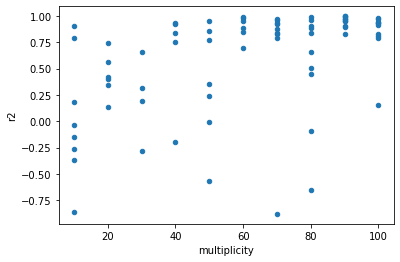

In [ ]:
# study the effects of multiplicity
result = pd.DataFrame(columns=["multiplicity", "r2"])

# DP parameters
eps = 1
delta = 0.05

for multiplicity in range(10,101,10):
    for _ in range(10):
        buyer_features=[]
        seller_features=['A', 'B', 'C']
        # number of rows
        size=100
        join, buyer, seller, parameters = generate_synthetic_datasets(buyer_features=buyer_features, seller_features=seller_features, size=size)

        # we use the original dataset without noise as testing data
        testdata = agg_dataset()
        testdata.load(join.copy(deep=True), seller_features+buyer_features + ["Y"],[])
        testdata.compute_agg()

        buyeragg = agg_dataset()
        buyeragg.load(buyer.copy(deep=True), buyer_features + ["Y"], ["join_key"])
        buyeragg.compute_agg()

        selleragg = agg_dataset()
        selleragg.load(seller.copy(deep=True), seller_features, ["join_key"])
        selleragg.compute_agg()

        noise = compute_std(eps, delta)

        # impute noise
        for col in selleragg.agg_dimensions["join_key"].columns:
            if col!= 'cov:c':
                selleragg.agg_dimensions["join_key"][col] += np.random.normal(0, noise, len(selleragg.agg_dimensions["join_key"]))/multiplicity

        join_test = connect(selleragg, buyeragg, "join_key")
        join_test_cov = join_test.sum()

        parameter = ridge_linear_regression(join_test_cov,["A","B","C"], "Y",0)
        final_r2 = r2(testdata.data.sum(),["A","B","C"], "Y", parameter)
        result = result.append([{'multiplicity':multiplicity,"r2":final_r2}], ignore_index=True)
        
result[result['r2']>-1].plot.scatter(x='multiplicity',y='r2')